In [1]:
# pip install cython owlready2 networkx matplotlib
import owlready2
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from itertools import combinations

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


### Download and load Cell Ontology
More info: https://www.ebi.ac.uk/ols4/ontologies/cl

In [2]:
onto_url = "http://purl.obolibrary.org/obo/cl.owl"
ontology = owlready2.get_ontology(onto_url).load()

### Use networkx to build directed aciclic graph (tree) with the ontology terms

In [3]:
graph = nx.DiGraph()
for thing in ontology.classes():
    # only superclase that match an entity, skip restrictions or other stuff
    superclasses = [is_a for is_a in thing.is_a if type(is_a) == owlready2.entity.ThingClass]
    for sub in superclasses:
        # add_edge will create the nodes if they don't exist
        graph.add_edge(sub, thing)

* Owlready2 * Warning: ignoring cyclic subclass of/subproperty of, involving:
  http://purl.obolibrary.org/obo/BFO_0000023
  http://purl.obolibrary.org/obo/CHEBI_50906

* Owlready2 * Warning: ignoring cyclic subclass of/subproperty of, involving:
  http://purl.obolibrary.org/obo/CHEBI_36080
  http://purl.obolibrary.org/obo/PR_000000001



In [4]:
# is the ontology a DAG (directed acyclic graph)?
nx.is_directed_acyclic_graph(graph)

True

### Example cells we'll use to lookup common ancestor

#### Note on searching the ontology
One way of searching i using the label:

```python
match = ontology.search_one(label="T cell", _case_sensitive=False)
```

Another way is searching if it has synonym:
```python
match = ontology.search_one(hasExactSynonym="T-cell", _case_sensitive=False)
```

In [12]:
thymocyte = ontology.search_one(label="thymocyte", _case_sensitive=False)
print(thymocyte,thymocyte.label)

obo.CL_0000893 ['thymocyte']


In [13]:
reg_t_cell = ontology.search_one(label="regulatory T cell", _case_sensitive=False)
print(reg_t_cell,reg_t_cell.label)

obo.CL_0000815 ['regulatory T cell']


In [15]:
type(thymocyte)

owlready2.entity.ThingClass

### Find common ancestor

In [16]:
common_ancestor = nx.lowest_common_ancestor(graph, thymocyte, reg_t_cell)

In [17]:
common_ancestor.label

['T cell']

### Plot subtree between selected cells and common ancestor

#### Get the nodes between the nodes and the ancestor

In [18]:
subset = set()
# for each term get all the nodes between common ancestor and a cell
for cl in [thymocyte, reg_t_cell]: 
    subset.add(cl)
    # get the shortest path between a two nodes
    for node in nx.shortest_path(graph, common_ancestor, cl):
        subset.add(node)

In [19]:
subset

{obo.CL_0000084,
 obo.CL_0000815,
 obo.CL_0000893,
 obo.CL_0002419,
 obo.CL_0002420}

In [20]:
for i in subset:
    print(i.label)

['T cell']
['mature T cell']
['thymocyte']
['immature T cell']
['regulatory T cell']


### Subset the graph to the selected nodes

In [21]:
# create a subgraph with the selected nodes
subgraph = graph.subgraph( subset )

### Plot nicely

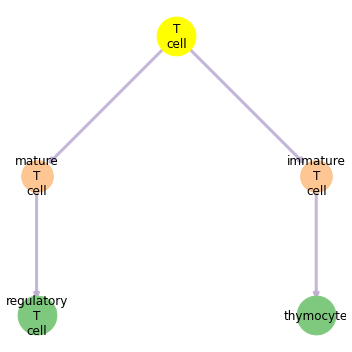

In [23]:
# To use 'graphviz_layout' the following package is required:
#   conda install -c conda-forge pygraphviz pydot
# if that fails then dependencies need to be installed at an OS level :(
#   sudo apt-get install python3-pydot python3-pydot-ng graphviz
node_positions = nx.nx_agraph.graphviz_layout(subgraph, prog="dot")

plt.figure(figsize=(5,5))
ax = plt.gca()

# draw all nodes and edges
nx.draw(
    G           = subgraph,
    pos         = node_positions,
    ax          = ax,
    node_color  = '#fdc086',
    node_size   = 1000,
    edge_color  = "#beaed4",
    width       = 3,
    alpha       = 0.9,
    with_labels = False)

# highlight main nodes
nx.draw_networkx_nodes(
    G           = subgraph,
    pos         = node_positions,
    ax          = ax,
    node_size   = 1500,
    nodelist    = [thymocyte, reg_t_cell],
    node_color  = "#7fc97f")

# highlight ancestor
nx.draw_networkx_nodes(
    G           = subgraph,
    pos         = node_positions,
    ax          = ax,
    node_size   = 1500,
    nodelist    = [common_ancestor],
    node_color  = "#ffff00")

# add labels
node_labels   = {node: "\n".join(node.label[0].split(" ")) if node.label else str(node) for node in subgraph.nodes()}
nx.draw_networkx_labels(
    G           = subgraph, 
    pos         = node_positions,
    ax          = ax,
    labels      = node_labels, 
    font_size   = 12,
    font_color  = "black")

plt.tight_layout()
plt.axis("off")
plt.show()

---

In [5]:
import scanpy as sc

In [27]:
adata = sc.read('/lustre/scratch127/cellgen/cellgeni/cakirb/census/bonemarrow_scvi_celltypist.h5ad', backed = 'r')

In [28]:
adata

AnnData object with n_obs × n_vars = 605318 × 10000 backed at '/lustre/scratch127/cellgen/cellgeni/cakirb/census/bonemarrow_scvi_celltypist.h5ad'
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels in Adult_Bone_marrow_Royetal', 'over_clustering in Adult_Bone_marrow_Royetal', 'majority_voting in Adult_Bone_marrow_Royetal', 'conf_score in Adult_Bone_marrow_Royetal', 'B lymphoid in Adult_Bone_marrow_Royetal', 'B lymphoid (cycling) in Adult_Bone_marrow_Royetal', 'Early lymphoid in Adult_Bone_marrow_Royetal', 'Early myeloid in Adult_Bo

In [29]:
matched_ct = ['CD16-positive, CD56-dim natural killer cell, human',
              'natural killer cell',
              'mature NK T cell',
              'lymphocyte',
              'CD16-negative, CD56-bright natural killer cell, human',
              'pre-natural killer cell',
              'innate lymphoid cell',
              'immature innate lymphoid cell',
              'group 3 innate lymphoid cell',
              'group 2 innate lymphoid cell']

In [38]:
meta0 = adata.obs.loc[:,['predicted_labels in Adult_Human_Bone_marrow', 'over_clustering in Adult_Human_Bone_marrow', 'majority_voting in Adult_Human_Bone_marrow', 'conf_score in Adult_Human_Bone_marrow', 'cell_type', 'cell_type_ontology_term_id']]

In [39]:
meta0

,predicted_labels in Adult_Human_Bone_marrow,over_clustering in Adult_Human_Bone_marrow,majority_voting in Adult_Human_Bone_marrow,conf_score in Adult_Human_Bone_marrow,cell_type,cell_type_ontology_term_id
0,Classical monocytes,57,Classical monocytes,0.031867,lymphoid lineage restricted progenitor cell,CL:0000838
1,HSC/MPP,1817,Naive B cells,0.028267,pro-B cell,CL:0000826
2,HSC/MPP,57,Classical monocytes,0.123993,common lymphoid progenitor,CL:0000051
3,HSC/MPP,5,Classical monocytes,0.011773,pro-B cell,CL:0000826
4,Classical monocytes,57,Classical monocytes,0.093818,lymphoid lineage restricted progenitor cell,CL:0000838
...,...,...,...,...,...,...
605313,HSC/MPP,43,Classical monocytes,0.060292,professional antigen presenting cell,CL:0000145
605314,Non-classical monocytes,43,Classical monocytes,0.006194,professional antigen presenting cell,CL:0000145
605315,Classical monocytes,43,Classical monocytes,0.005384,professional antigen presenting cell,CL:0000145
605316,Non-classical monocytes,43,Classical monocytes,0.005239,professional antigen presenting cell,CL:0000145


In [42]:
meta0.index = meta0.cell_type

In [43]:
type(meta0.at['primordial germ cell', 'cell_type_ontology_term_id']) == str

True

### Match each census celltype to a single celltypist celltype

In [44]:
cell_type_match = pd.DataFrame(columns = ['majority_voting', 'cell_type'])
for i in adata.obs['cell_type'].unique():
    # check fraction (dot size)
    maj_voting_frac_i = meta0.loc[meta0['cell_type'] == i, 'majority_voting in Adult_Human_Bone_marrow'].value_counts(normalize=True)
    maj_voting_frac_i = list(maj_voting_frac_i[maj_voting_frac_i == maj_voting_frac_i.max()].index)
#     # check confidence (dot color)
#     maj_voting_scor_i = meta0.loc[meta0['cell_type'] == i, ['majority_voting in Adult_Human_Bone_marrow', 'conf_score in Adult_Human_Bone_marrow']]
#     maj_voting_scor_i = list(maj_voting_scor_i.groupby('majority_voting in Adult_Human_Bone_marrow').mean().sort_values(by='conf_score in Adult_Human_Bone_marrow', ascending = False).index[[0,1]])
#     maj_voting_i = set(maj_voting_frac_i).intersection(maj_voting_scor_i)
    cell_type_match = pd.concat([cell_type_match, pd.DataFrame({'majority_voting': [maj_voting_frac_i], 
                                                                'cell_type': [i], 
                                                                'cell_type_ontology_term_id': [meta0.at[i, 'cell_type_ontology_term_id'] \
                                                                                               if type(meta0.at[i, 'cell_type_ontology_term_id']) == str 
                                                                                               else meta0.at[i, 'cell_type_ontology_term_id'][0]]})], ignore_index = True)

In [45]:
cell_type_match = cell_type_match.explode('majority_voting')

In [46]:
cell_type_match

,majority_voting,cell_type,cell_type_ontology_term_id
0,HSC/MPP,lymphoid lineage restricted progenitor cell,CL:0000838
1,Naive B cells,pro-B cell,CL:0000826
2,HSC/MPP,common lymphoid progenitor,CL:0000051
3,Plasma cells,precursor B cell,CL:0000817
4,HSC/MPP,myeloid lineage restricted progenitor cell,CL:0000839
...,...,...,...
122,Classical monocytes,B cell,CL:0000236
123,Classical monocytes,cord blood hematopoietic stem cell,CL:2000095
124,Classical monocytes,primordial germ cell,CL:0000670
125,MEMP,stromal cell,CL:0000499


### Check CL terms for each celltypist celltype & find common ancestors for each pair

In [48]:
cell_types_ct = cell_type_match.majority_voting.unique()

ancestors = pd.DataFrame(columns = ['org_cell_type', 'pair', 'pair_thingclass', 'cell_type', 'cell_type_id'])
for celltype in cell_types_ct:
    orig_celltypes = cell_type_match.loc[cell_type_match.majority_voting == celltype, 'cell_type_ontology_term_id']
    if ((len(orig_celltypes) > 1) & (len(orig_celltypes) < 15)):
        print(f'{celltype} -> {len(orig_celltypes)} CL terms: {len(list(combinations(list(orig_celltypes), 2)))} combinations (pairs)')
        for pair in list(combinations(list(orig_celltypes), 2)):
            c1 = ontology.search_one(iri = f"*CL_{pair[0][3:]}")
            c2 = ontology.search_one(iri = f"*CL_{pair[1][3:]}")
            common_ancestor = nx.lowest_common_ancestor(graph, c1, c2)
            if common_ancestor.name.startswith('CL'):
                anc_name = common_ancestor.label[0]
            else:
                anc_name = f"{common_ancestor.label[0]} (not CL)"
            ancestors = pd.concat([ancestors, pd.DataFrame({'org_cell_type': [celltype], 
                                                            'pair': [pair], 
                                                            'pair_thingclass': [(c1,c2)],
                                                            'cell_type': [anc_name], 
                                                            'cell_type_id': [common_ancestor.name]}
                                                          )], ignore_index = True)

HSC/MPP -> 10 CL terms: 45 combinations (pairs)
Naive B cells -> 12 CL terms: 66 combinations (pairs)
Plasma cells -> 7 CL terms: 21 combinations (pairs)
Early erythroid -> 2 CL terms: 1 combinations (pairs)
Mast cells -> 5 CL terms: 10 combinations (pairs)
MEMP -> 4 CL terms: 6 combinations (pairs)
CD16+ NK cells -> 9 CL terms: 36 combinations (pairs)
Tcm/Naive helper T cells -> 13 CL terms: 78 combinations (pairs)
Tem/Temra cytotoxic T cells -> 5 CL terms: 10 combinations (pairs)
Tem/Trm cytotoxic T cells -> 6 CL terms: 15 combinations (pairs)
CMP -> 2 CL terms: 1 combinations (pairs)


In [49]:
ancestors

,org_cell_type,pair,pair_thingclass,cell_type,cell_type_id
0,HSC/MPP,"(CL:0000838, CL:0000051)","(obo.CL_0000838, obo.CL_0000051)",progenitor cell,CL_0011026
1,HSC/MPP,"(CL:0000838, CL:0000839)","(obo.CL_0000838, obo.CL_0000839)",hematopoietic lineage restricted progenitor cell,CL_0002031
2,HSC/MPP,"(CL:0000838, CL:0000837)","(obo.CL_0000838, obo.CL_0000837)",hematopoietic precursor cell,CL_0008001
3,HSC/MPP,"(CL:0000838, CL:0000936)","(obo.CL_0000838, obo.CL_0000936)",progenitor cell,CL_0011026
4,HSC/MPP,"(CL:0000838, CL:0000823)","(obo.CL_0000838, obo.CL_0000823)",hematopoietic cell,CL_0000988
...,...,...,...,...,...
284,Tem/Trm cytotoxic T cells,"(CL:0000913, CL:0001203)","(obo.CL_0000913, obo.CL_0001203)","CD8-positive, alpha-beta memory T cell, CD45RO...",CL_0001203
285,Tem/Trm cytotoxic T cells,"(CL:0000798, CL:0000934)","(obo.CL_0000798, obo.CL_0000934)",T cell,CL_0000084
286,Tem/Trm cytotoxic T cells,"(CL:0000798, CL:0001203)","(obo.CL_0000798, obo.CL_0001203)",T cell,CL_0000084
287,Tem/Trm cytotoxic T cells,"(CL:0000934, CL:0001203)","(obo.CL_0000934, obo.CL_0001203)",mature alpha-beta T cell,CL_0000791


In [50]:
ancestors.groupby('org_cell_type')['cell_type'].value_counts()

org_cell_type                cell_type                                              
CD16+ NK cells               innate lymphoid cell                                       15
                             lymphocyte                                                 15
                             natural killer cell                                         5
                             mature natural killer cell                                  1
CMP                          promyelocyte                                                1
Early erythroid              erythroid lineage cell                                      1
HSC/MPP                      progenitor cell                                             9
                             hematopoietic cell                                          8
                             somatic cell                                                6
                             precursor cell                                              5
     

In [51]:
pd.DataFrame(ancestors.groupby('org_cell_type')['cell_type'].value_counts())

cell_type
org_cell_type               cell_type                                                    
CD16+ NK cells              innate lymphoid cell                                       15
                            lymphocyte                                                 15
                            natural killer cell                                         5
                            mature natural killer cell                                  1
CMP                         promyelocyte                                                1
Early erythroid             erythroid lineage cell                                      1
HSC/MPP                     progenitor cell                                             9
                            hematopoietic cell                                          8
                            somatic cell                                                6
                            precursor cell                                              5
                            hematopoietic precursor cell                                4
                            native cell                                                 4
                            protein-containing material entity (not CL)                 4
                            motile cell                                                 2
                            hematopoietic lineage restricted progenitor cell            1
                            hematopoietic multipotent progenitor cell                   1
                            lymphocyte                                                  1
MEMP                        somatic cell                                                3
                            myeloid cell                                                2
                            hematopoietic precursor cell                                1
Mast cells                  protein-containing material entity (not CL)                 4
                            granulocyte                                                 3
                            myeloid leukocyte                                           3
Naive B cells               mature B cell                                              20
                            protein-containing material entity (not CL)                18
                            somatic cell                                               11
                            lymphocyte                                                  8
                            B cell, CD19-positive                                       7
                            memory B cell                                               1
                            pro-B cell                                                  1
Plasma cells                protein-containing material entity (not CL)                 6
                            mononuclear cell                                            4
                            B cell, CD19-positive                                       3
                            lymphocyte of B lineage                                     3
                            precursor B cell                                            2
                            antibody secreting cell                                     1
                            pre-B-II cell                                               1
                            professional antigen presenting cell                        1
Tcm/Naive helper T cells    mature alpha-beta T cell                                   20
                            alpha-beta T cell                                          18
                            T cell                                                     14
                            CD4-positive, alpha-beta T cell                            13
                            mature T cell                                               9
                            CD

Cannot match one celltypist celltype to one ancestor, therefore try to find upper level ancestor 

### Find the ancestors at one upper level

In [53]:
ancestors2 = pd.DataFrame(columns = ['org_cell_type', 'pair', 'pair_label', 'cell_type', 'cell_type_id'])
for celltype in ancestors.org_cell_type.unique():
    cl_list = ancestors.loc[ancestors.org_cell_type == celltype, 'cell_type_id'].unique()
    ind = [item.startswith('CL') for item in cl_list]
    cl_list = cl_list[ind]
    for pair in list(combinations(list(cl_list), 2)):
        c1 = ontology.search_one(iri = f"*CL_{pair[0][3:]}")
        c2 = ontology.search_one(iri = f"*CL_{pair[1][3:]}")
        common_ancestor = nx.lowest_common_ancestor(graph, c1, c2)
        if common_ancestor.name.startswith('CL'):
            anc_name = common_ancestor.label[0]
        else:
            anc_name = f"{common_ancestor.label[0]} (not CL)"
        ancestors2 = pd.concat([ancestors2, pd.DataFrame({'org_cell_type': [celltype], 
                                                        'pair': [pair], 
                                                        'pair_label': [(c1.label[0], c2.label[0])],
                                                        'cell_type': [anc_name], 
                                                        'cell_type_id': [common_ancestor.name]}
                                                      )], ignore_index = True)

In [54]:
ancestors2

,org_cell_type,pair,pair_label,cell_type,cell_type_id
0,HSC/MPP,"(CL_0011026, CL_0002031)","(progenitor cell, hematopoietic lineage restri...",native cell,CL_0000003
1,HSC/MPP,"(CL_0011026, CL_0008001)","(progenitor cell, hematopoietic precursor cell)",native cell,CL_0000003
2,HSC/MPP,"(CL_0011026, CL_0000988)","(progenitor cell, hematopoietic cell)",native cell,CL_0000003
3,HSC/MPP,"(CL_0011026, CL_0002371)","(progenitor cell, somatic cell)",native cell,CL_0000003
4,HSC/MPP,"(CL_0011026, CL_0011115)","(progenitor cell, precursor cell)",precursor cell,CL_0011115
...,...,...,...,...,...
131,Tem/Trm cytotoxic T cells,"(CL_0000789, CL_0001203)","(alpha-beta T cell, CD8-positive, alpha-beta m...",alpha-beta T cell,CL_0000789
132,Tem/Trm cytotoxic T cells,"(CL_0000789, CL_0000791)","(alpha-beta T cell, mature alpha-beta T cell)",alpha-beta T cell,CL_0000789
133,Tem/Trm cytotoxic T cells,"(CL_0000084, CL_0001203)","(T cell, CD8-positive, alpha-beta memory T cel...",T cell,CL_0000084
134,Tem/Trm cytotoxic T cells,"(CL_0000084, CL_0000791)","(T cell, mature alpha-beta T cell)",T cell,CL_0000084


In [55]:
pd.DataFrame(ancestors2.groupby('org_cell_type')['cell_type'].value_counts())

cell_type
org_cell_type               cell_type                                             
CD16+ NK cells              lymphocyte                                           3
                            innate lymphoid cell                                 2
                            natural killer cell                                  1
HSC/MPP                     native cell                                         28
                            hematopoietic cell                                   6
                            somatic cell                                         5
                            hematopoietic precursor cell                         3
                            motile cell                                          1
                            precursor cell                                       1
                            protein-containing material entity (not CL)          1
MEMP                        somatic cell                                         2
                            hematopoietic cell                                   1
Mast cells                  myeloid leukocyte                                    1
Naive B cells               somatic cell                                         5
                            protein-containing material entity (not CL)          4
                            lymphocyte                                           3
                            B cell, CD19-positive                                2
                            mature B cell                                        1
Plasma cells                lymphocyte of B lineage                              7
                            leukocyte                                            6
                            mononuclear cell                                     5
                            B cell, CD19-positive                                2
                            precursor B cell                                     1
Tcm/Naive helper T cells    alpha-beta T cell                                   11
                            T cell                                              10
                            mature alpha-beta T cell                             7
                            mature T cell                                        5
                            CD4-positive, alpha-beta T cell                      3
Tem/Temra cytotoxic T cells alpha-beta T cell                                    2
                            mature alpha-beta T cell                             1
Tem/Trm cytotoxic T cells   T cell                                               3
                            alpha-beta T cell                                    2
                            mature alpha-beta T cell                             1

Previous:

In [56]:
ancestors2[ancestors2.org_cell_type == 'CD16+ NK cells']

,org_cell_type,pair,pair_label,cell_type,cell_type_id
85,CD16+ NK cells,"(CL_0000623, CL_0000542)","(natural killer cell, lymphocyte)",lymphocyte,CL_0000542
86,CD16+ NK cells,"(CL_0000623, CL_0001065)","(natural killer cell, innate lymphoid cell)",innate lymphoid cell,CL_0001065
87,CD16+ NK cells,"(CL_0000623, CL_0000824)","(natural killer cell, mature natural killer cell)",natural killer cell,CL_0000623
88,CD16+ NK cells,"(CL_0000542, CL_0001065)","(lymphocyte, innate lymphoid cell)",lymphocyte,CL_0000542
89,CD16+ NK cells,"(CL_0000542, CL_0000824)","(lymphocyte, mature natural killer cell)",lymphocyte,CL_0000542
90,CD16+ NK cells,"(CL_0001065, CL_0000824)","(innate lymphoid cell, mature natural killer c...",innate lymphoid cell,CL_0001065


In [65]:
ancestors2.org_cell_type.unique()

array(['HSC/MPP', 'Naive B cells', 'Plasma cells', 'Mast cells', 'MEMP',
       'CD16+ NK cells', 'Tcm/Naive helper T cells',
       'Tem/Temra cytotoxic T cells', 'Tem/Trm cytotoxic T cells'],
      dtype=object)

In [66]:
import pandas as pd

# Assuming you have the result of ancestors2.groupby('org_cell_type')['cell_type'].value_counts() stored in a variable called 'counts'
counts = ancestors2.groupby('org_cell_type')['cell_type'].value_counts()

# Find the index with the highest count for each 'org_cell_type'
idx = counts.groupby(level='org_cell_type').idxmax()

# Get the highest frequency of 'cell_type' for each 'org_cell_type'
highest_freq = counts.loc[idx]

# Print the highest frequency of 'cell_type' for each 'org_cell_type'
print(highest_freq)


org_cell_type                cell_type              
CD16+ NK cells               lymphocyte                  3
HSC/MPP                      native cell                28
MEMP                         somatic cell                2
Mast cells                   myeloid leukocyte           1
Naive B cells                somatic cell                5
Plasma cells                 lymphocyte of B lineage     7
Tcm/Naive helper T cells     alpha-beta T cell          11
Tem/Temra cytotoxic T cells  alpha-beta T cell           2
Tem/Trm cytotoxic T cells    T cell                      3
Name: cell_type, dtype: int64


In [136]:
x = pd.DataFrame(ancestors2.groupby('org_cell_type')['cell_type'].value_counts().groupby(level='org_cell_type').nlargest(1))

In [137]:
x.index = x.index.set_names('org_ct2', level=1)

In [147]:
x = x.rename(columns={'cell_type': 'freq_cell_type'}).reset_index()

In [149]:
x.loc[:,x.columns != 'org_ct2']

,org_cell_type,cell_type,freq_cell_type
0,CD16+ NK cells,lymphocyte,3
1,HSC/MPP,native cell,28
2,MEMP,somatic cell,2
3,Mast cells,myeloid leukocyte,1
4,Naive B cells,somatic cell,5
5,Plasma cells,lymphocyte of B lineage,7
6,Tcm/Naive helper T cells,alpha-beta T cell,11
7,Tem/Temra cytotoxic T cells,alpha-beta T cell,2
8,Tem/Trm cytotoxic T cells,T cell,3


In [77]:
pd.DataFrame(ancestors2.groupby('org_cell_type')['cell_type'].value_counts())

cell_type
org_cell_type               cell_type                                             
CD16+ NK cells              lymphocyte                                           3
                            innate lymphoid cell                                 2
                            natural killer cell                                  1
HSC/MPP                     native cell                                         28
                            hematopoietic cell                                   6
                            somatic cell                                         5
                            hematopoietic precursor cell                         3
                            motile cell                                          1
                            precursor cell                                       1
                            protein-containing material entity (not CL)          1
MEMP                        somatic cell                                         2
                            hematopoietic cell                                   1
Mast cells                  myeloid leukocyte                                    1
Naive B cells               somatic cell                                         5
                            protein-containing material entity (not CL)          4
                            lymphocyte                                           3
                            B cell, CD19-positive                                2
                            mature B cell                                        1
Plasma cells                lymphocyte of B lineage                              7
                            leukocyte                                            6
                            mononuclear cell                                     5
                            B cell, CD19-positive                                2
                            precursor B cell                                     1
Tcm/Naive helper T cells    alpha-beta T cell                                   11
                            T cell                                              10
                            mature alpha-beta T cell                             7
                            mature T cell                                        5
                            CD4-positive, alpha-beta T cell                      3
Tem/Temra cytotoxic T cells alpha-beta T cell                                    2
                            mature alpha-beta T cell                             1
Tem/Trm cytotoxic T cells   T cell                                               3
                            alpha-beta T cell                                    2
                            mature alpha-beta T cell                             1

In [76]:
ancestors.groupby('org_cell_type')['cell_type'].value_counts()

org_cell_type                cell_type                                              
CD16+ NK cells               innate lymphoid cell                                       15
                             lymphocyte                                                 15
                             natural killer cell                                         5
                             mature natural killer cell                                  1
CMP                          promyelocyte                                                1
Early erythroid              erythroid lineage cell                                      1
HSC/MPP                      progenitor cell                                             9
                             hematopoietic cell                                          8
                             somatic cell                                                6
                             precursor cell                                              5
     

In [80]:
ancestors2[['org_cell_type', 'cell_type']].drop_duplicates()

,org_cell_type,cell_type
0,HSC/MPP,native cell
4,HSC/MPP,precursor cell
9,HSC/MPP,hematopoietic precursor cell
10,HSC/MPP,hematopoietic cell
11,HSC/MPP,somatic cell
40,HSC/MPP,protein-containing material entity (not CL)
44,HSC/MPP,motile cell
45,Naive B cells,somatic cell
46,Naive B cells,protein-containing material entity (not CL)
54,Naive B cells,lymphocyte


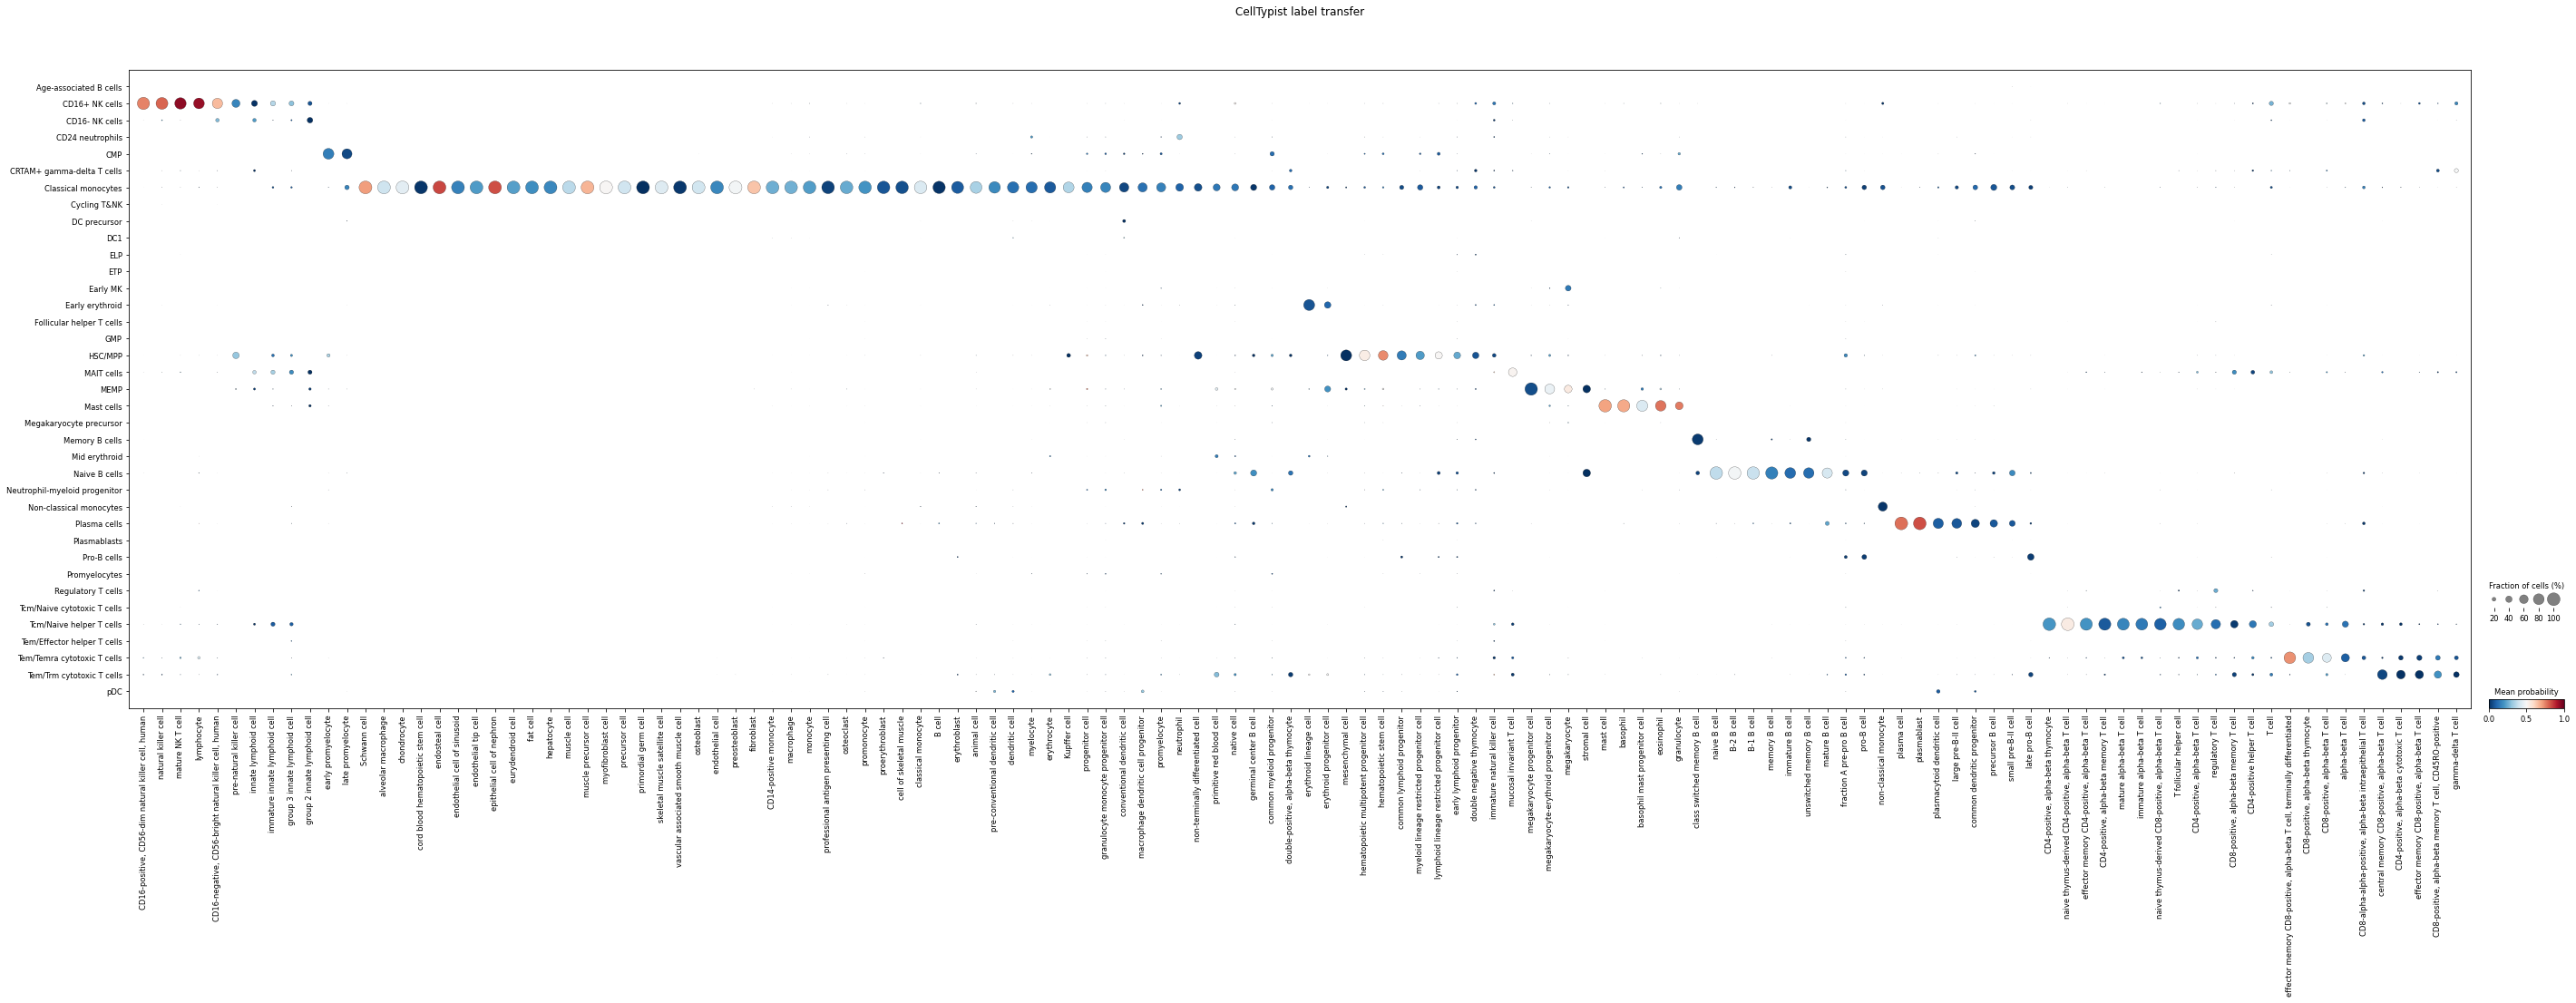

In [14]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'majority_voting')

### Match each census celltype to a single celltypist celltype (using CL)

In [10]:
import scanpy as sc

In [11]:
adata = sc.read('/lustre/scratch127/cellgen/cellgeni/cakirb/census/bonemarrow_scvi_celltypist.h5ad', backed = 'r')

In [12]:
adata

AnnData object with n_obs × n_vars = 605318 × 10000 backed at '/lustre/scratch127/cellgen/cellgeni/cakirb/census/bonemarrow_scvi_celltypist.h5ad'
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels in Adult_Bone_marrow_Royetal', 'over_clustering in Adult_Bone_marrow_Royetal', 'majority_voting in Adult_Bone_marrow_Royetal', 'conf_score in Adult_Bone_marrow_Royetal', 'B lymphoid in Adult_Bone_marrow_Royetal', 'B lymphoid (cycling) in Adult_Bone_marrow_Royetal', 'Early lymphoid in Adult_Bone_marrow_Royetal', 'Early myeloid in Adult_Bo

#### Retrieve cell types in adata with CL terms

In [78]:
celltypes_adata = adata.obs[['cell_type', 'cell_type_ontology_term_id']].drop_duplicates()
celltypes_adata.index = celltypes_adata.cell_type
celltypes_adata = celltypes_adata['cell_type_ontology_term_id']
celltypes_adata = celltypes_adata.to_dict()

In [79]:
celltypes_adata

{'lymphoid lineage restricted progenitor cell': 'CL:0000838',
 'pro-B cell': 'CL:0000826',
 'common lymphoid progenitor': 'CL:0000051',
 'precursor B cell': 'CL:0000817',
 'myeloid lineage restricted progenitor cell': 'CL:0000839',
 'hematopoietic multipotent progenitor cell': 'CL:0000837',
 'erythroid progenitor cell': 'CL:0000038',
 'common dendritic progenitor': 'CL:0001029',
 'granulocyte': 'CL:0000094',
 'megakaryocyte-erythroid progenitor cell': 'CL:0000050',
 'erythroblast': 'CL:0000765',
 'proerythroblast': 'CL:0000547',
 'primitive red blood cell': 'CL:0002355',
 'fraction A pre-pro B cell': 'CL:0002045',
 'promonocyte': 'CL:0000559',
 'neutrophil': 'CL:0000775',
 'immature B cell': 'CL:0000816',
 'CD14-positive monocyte': 'CL:0001054',
 'erythrocyte': 'CL:0000232',
 'macrophage': 'CL:0000235',
 'promyelocyte': 'CL:0000836',
 'dendritic cell': 'CL:0000451',
 'progenitor cell': 'CL:0011026',
 'endothelial cell of sinusoid': 'CL:0002262',
 'granulocyte monocyte progenitor cell':

#### Retrieve cell types in celltypist model with CL terms

In [80]:
cl_terms = pd.read_csv('/home/jovyan/cakirb/census/bone_marrow/CL_terms_Adult_Human_Bone_marrow_model.csv')

In [81]:
cl_terms.index = cl_terms.Cell_type
cl_terms = cl_terms['Cell_ontology_ID']

In [82]:
cl_terms = cl_terms.to_dict()

#### Find the pairs between celltypist cell type and census cell type based on the size of dots

In [83]:
dot_size_df = pd.read_csv('/home/jovyan/cakirb/census/bone_marrow/celltypist_dotsize.csv', index_col=0)

In [84]:
dot_size_df

,"CD16-positive, CD56-dim natural killer cell, human","CD16-negative, CD56-bright natural killer cell, human",natural killer cell,mature NK T cell,lymphocyte,pre-natural killer cell,innate lymphoid cell,immature innate lymphoid cell,group 3 innate lymphoid cell,group 2 innate lymphoid cell,...,"CD8-positive, alpha-beta memory T cell",T cell,"effector memory CD8-positive, alpha-beta T cell, terminally differentiated","CD8-positive, alpha-beta thymocyte","CD8-positive, alpha-beta T cell","effector memory CD8-positive, alpha-beta T cell","CD8-alpha-alpha-positive, alpha-beta intraepithelial T cell","central memory CD8-positive, alpha-beta T cell","CD4-positive, alpha-beta cytotoxic T cell","CD8-positive, alpha-beta memory T cell, CD45RO-positive"
Age-associated B cells,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD16+ NK cells,0.962498,0.929110,0.911751,0.860941,0.801180,0.540541,0.363636,0.298507,0.282297,0.222222,...,0.031649,0.220488,0.080790,0.000000,0.039447,0.248416,0.133333,0.072566,0.107399,0.015199
CD16- NK cells,0.000000,0.012066,0.032513,0.004090,0.000000,0.000000,0.090909,0.014925,0.047847,0.333333,...,0.000000,0.035122,0.000000,0.000000,0.000883,0.000000,0.133333,0.000000,0.000000,0.000000
CD24 neutrophils,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CMP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CRTAM+ gamma-delta T cells,0.000182,0.012821,0.003948,0.013633,0.004720,0.000000,0.090909,0.000000,0.014354,0.000000,...,0.005478,0.023415,0.012867,0.000000,0.073594,0.000000,0.000000,0.000000,0.000000,0.153022
Classical monocytes,0.000137,0.005279,0.005341,0.004090,0.010619,0.000000,0.090909,0.044776,0.047847,0.000000,...,0.000609,0.106341,0.000598,0.000000,0.003533,0.000226,0.133333,0.000370,0.000000,0.001036
Cycling T&NK,0.000000,0.000377,0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DC precursor,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DC1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [85]:
pairs_name = []
for i in dot_size_df.columns:
    pairs_name.append((dot_size_df[i].idxmax(), i))

In [94]:
pairs_name

[('CD16+ NK cells', 'CD16-positive, CD56-dim natural killer cell, human'),
 ('CD16+ NK cells', 'CD16-negative, CD56-bright natural killer cell, human'),
 ('CD16+ NK cells', 'natural killer cell'),
 ('CD16+ NK cells', 'mature NK T cell'),
 ('CD16+ NK cells', 'lymphocyte'),
 ('CD16+ NK cells', 'pre-natural killer cell'),
 ('CD16+ NK cells', 'innate lymphoid cell'),
 ('CD16+ NK cells', 'immature innate lymphoid cell'),
 ('CD16+ NK cells', 'group 3 innate lymphoid cell'),
 ('CD16- NK cells', 'group 2 innate lymphoid cell'),
 ('CMP', 'early promyelocyte'),
 ('CRTAM+ gamma-delta T cells', 'gamma-delta T cell'),
 ('Classical monocytes', 'Schwann cell'),
 ('Classical monocytes', 'alveolar macrophage'),
 ('Classical monocytes', 'chondrocyte'),
 ('Classical monocytes', 'endosteal cell'),
 ('Classical monocytes', 'endothelial cell of sinusoid'),
 ('Classical monocytes', 'endothelial tip cell'),
 ('Classical monocytes', 'epithelial cell of nephron'),
 ('Classical monocytes', 'eurydendroid cell'),


In [86]:
ct_cl = []
for ct in list(dot_size_df.columns):
    ct_cl.append(celltypes_adata[ct])
dot_size_df.columns = ct_cl
ct_cl = []
for ct in list(dot_size_df.index):
    ct_cl.append(cl_terms[ct])
dot_size_df.index = ct_cl

In [87]:
dot_size_df

,CL:0000939,CL:0000938,CL:0000623,CL:0000814,CL:0000542,CL:0000937,CL:0001065,CL:0001082,CL:0001071,CL:0001069,...,CL:0000909,CL:0000084,CL:0001062,CL:0000811,CL:0000625,CL:0000913,CL:0000915,CL:0000907,CL:0000934,CL:0001203
CL:0000236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL:0000939,0.962498,0.929110,0.911751,0.860941,0.801180,0.540541,0.363636,0.298507,0.282297,0.222222,...,0.031649,0.220488,0.080790,0.000000,0.039447,0.248416,0.133333,0.072566,0.107399,0.015199
CL:0000938,0.000000,0.012066,0.032513,0.004090,0.000000,0.000000,0.090909,0.014925,0.047847,0.333333,...,0.000000,0.035122,0.000000,0.000000,0.000883,0.000000,0.133333,0.000000,0.000000,0.000000
CL:0000775,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL:0000049,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL:0000798,0.000182,0.012821,0.003948,0.013633,0.004720,0.000000,0.090909,0.000000,0.014354,0.000000,...,0.005478,0.023415,0.012867,0.000000,0.073594,0.000000,0.000000,0.000000,0.000000,0.153022
CL:0000860,0.000137,0.005279,0.005341,0.004090,0.010619,0.000000,0.090909,0.044776,0.047847,0.000000,...,0.000609,0.106341,0.000598,0.000000,0.003533,0.000226,0.133333,0.000370,0.000000,0.001036
CL:0000814,0.000000,0.000377,0.000929,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL:0000451,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL:0000990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [92]:
pairs_cl = []
for i in dot_size_df.columns:
    pairs_cl.append((dot_size_df[i].idxmax(), i))

In [93]:
pairs_cl

[('CL:0000939', 'CL:0000939'),
 ('CL:0000939', 'CL:0000938'),
 ('CL:0000939', 'CL:0000623'),
 ('CL:0000939', 'CL:0000814'),
 ('CL:0000939', 'CL:0000542'),
 ('CL:0000939', 'CL:0000937'),
 ('CL:0000939', 'CL:0001065'),
 ('CL:0000939', 'CL:0001082'),
 ('CL:0000939', 'CL:0001071'),
 ('CL:0000938', 'CL:0001069'),
 ('CL:0000049', 'CL:0002154'),
 ('CL:0000798', 'CL:0000798'),
 ('CL:0000860', 'CL:0002573'),
 ('CL:0000860', 'CL:0000583'),
 ('CL:0000860', 'CL:0000138'),
 ('CL:0000860', 'CL:0002157'),
 ('CL:0000860', 'CL:0002262'),
 ('CL:0000860', 'CL:0000704'),
 ('CL:0000860', 'CL:1000449'),
 ('CL:0000860', 'CL:0000253'),
 ('CL:0000860', 'CL:0000136'),
 ('CL:0000860', 'CL:0000182'),
 ('CL:0000860', 'CL:0000187'),
 ('CL:0000860', 'CL:0000680'),
 ('CL:0000860', 'CL:0000186'),
 ('CL:0000860', 'CL:0011115'),
 ('CL:0000860', 'CL:0000670'),
 ('CL:0000860', 'CL:0000594'),
 ('CL:0000860', 'CL:0000359'),
 ('CL:0000860', 'CL:0000062'),
 ('CL:0000860', 'CL:0000115'),
 ('CL:0000860', 'CL:0007010'),
 ('CL:00

#### Create the dataframe with lowest common ancestor and distance info

In [124]:
ancestors = pd.DataFrame(columns = ['pair', 'pair_obo', 'cell_type', 'cell_type_id', 'one_of_them', 'distance_c1_common', 'distance_c2_common'])
ancestors.one_of_them = ancestors.one_of_them.astype('bool')
for pairname, pair in zip(pairs_name, pairs_cl):
    c1 = ontology.search_one(iri = f"*CL_{pair[0][3:]}")
    c2 = ontology.search_one(iri = f"*CL_{pair[1][3:]}")
    common_ancestor = nx.lowest_common_ancestor(graph, c1, c2)
    if common_ancestor.name.startswith('CL'):
        anc_name = common_ancestor.label[0]
    else:
        anc_name = f"{common_ancestor.label[0]} (not CL)"
    ancestors = pd.concat([ancestors, pd.DataFrame({'pair': [pairname], 
                                                    'pair_obo': [(c1,c2)],
                                                    'cell_type': anc_name, 
                                                    'cell_type_id': common_ancestor.name,
                                                    'one_of_them': True if anc_name in pairname else False,
                                                    'distance_c1_common': nx.shortest_path_length(graph, common_ancestor, c1),
                                                    'distance_c2_common': nx.shortest_path_length(graph, common_ancestor, c2)                                                  }
                                                  )], ignore_index = True)

In [125]:
ancestors

,pair,pair_obo,cell_type,cell_type_id,one_of_them,distance_c1_common,distance_c2_common
0,"(CD16+ NK cells, CD16-positive, CD56-dim natur...","(obo.CL_0000939, obo.CL_0000939)","CD16-positive, CD56-dim natural killer cell, h...",CL_0000939,True,0,0
1,"(CD16+ NK cells, CD16-negative, CD56-bright na...","(obo.CL_0000939, obo.CL_0000938)",mature natural killer cell,CL_0000824,False,1,1
2,"(CD16+ NK cells, natural killer cell)","(obo.CL_0000939, obo.CL_0000623)",natural killer cell,CL_0000623,True,2,0
3,"(CD16+ NK cells, mature NK T cell)","(obo.CL_0000939, obo.CL_0000814)",lymphocyte,CL_0000542,False,5,4
4,"(CD16+ NK cells, lymphocyte)","(obo.CL_0000939, obo.CL_0000542)",lymphocyte,CL_0000542,True,5,0
...,...,...,...,...,...,...,...
121,"(Tem/Temra cytotoxic T cells, effector memory ...","(obo.CL_0000910, obo.CL_0000913)",mature T cell,CL_0002419,False,2,4
122,"(Tem/Temra cytotoxic T cells, CD8-alpha-alpha-...","(obo.CL_0000910, obo.CL_0000915)",mature T cell,CL_0002419,False,2,3
123,"(Tem/Trm cytotoxic T cells, central memory CD8...","(obo.CL_0000910, obo.CL_0000907)",mature T cell,CL_0002419,False,2,4
124,"(Tem/Trm cytotoxic T cells, CD4-positive, alph...","(obo.CL_0000910, obo.CL_0000934)",mature T cell,CL_0002419,False,2,3


In [126]:
ancestors.pair_obo = pairs_cl

In [128]:
ancestors.to_csv('bonemarrow_commonancestors_distance_all.csv', index=False)

In [129]:
ancestors[ancestors.one_of_them == False].to_csv('bonemarrow_commonancestors_distance_2.csv', index=False)